In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

In [17]:
import seaborn as sns
import pandas as pd


_ = sns.set_style('whitegrid')

# Probabilistic layers

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

#### Create data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{3}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

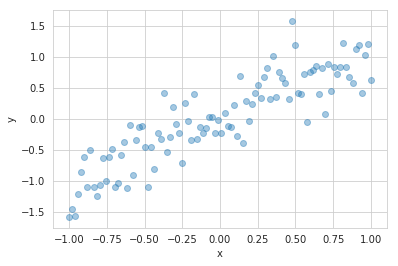

In [45]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


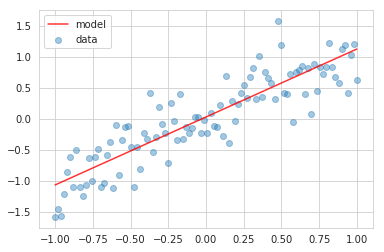

In [46]:
# Create and train deterministic linear model using mean squared error loss

# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [49]:
# Examine the model predictions

x_train.shape, model.predict(x_train[:10])

((100, 1), array([[-1.0658528 ],
        [-1.0437579 ],
        [-1.0216631 ],
        [-0.9995682 ],
        [-0.97747326],
        [-0.9553785 ],
        [-0.9332836 ],
        [-0.9111887 ],
        [-0.88909394],
        [-0.86699903]], dtype=float32))

#### Probabilistic linear regression with both user-defined and learned variance

In the following cell, we will create a model with a leant mean and fixed stdev.

In [112]:
# Create probabilistic regression with normal distribution as final layer

# fitting mean only.
n_epochs = 20
model = Sequential([
    Dense(units=1, input_shape=(1,)), # 1 loc
    tfpl.DistributionLambda(
        lambda x: tfd.Independent(tfd.Normal(loc=x, scale=1)) # we are fixing the stdev to 1.
    )
])

# summary
model.summary()

# Train model using the negative loglikelihood
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=1000)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_10 (Dist ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 1s 5ms/sample - loss: 1.1851
Epoch 2/1000
100/100 [==============================] - 0s 43us/sample - loss: 1.1821
Epoch 3/1000
100/100 [==============================] - 0s 46us/sample - loss: 1.1800
Epoch 4/1000
100/100 [==============================] - 0s 37us/sample - loss: 1.1783
Epoch 5/1000
100/100 [==============================] - 0s 38us/sample - loss: 1.1768
Epoch 6/1000
100/100 [==============================] - 0s 40us/sample 

In [109]:
# Examine the distribution created as a feedforward value

model.predict(x_train).shape

(100, 1)

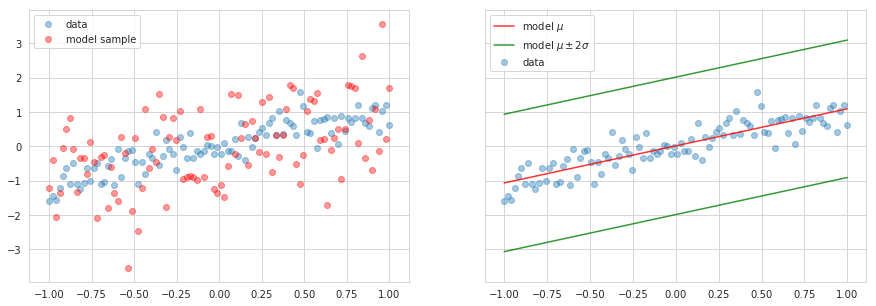

In [111]:
# Plot the data and a sample from the model

def _plot(x_train, y_train, model):
    y_model = model(x_train)
    y_sample = y_model.sample()
    y_hat = y_model.mean()
    y_sd = y_model.stddev()
    y_hat_m2sd = y_hat - 2 * y_sd
    y_hat_p2sd = y_hat + 2 * y_sd

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    ax1.scatter(x_train, y_train, alpha=0.4, label='data')
    ax1.scatter(x_train, y_sample, alpha=0.4, color='red', label='model sample')
    ax1.legend()
    ax2.scatter(x_train, y_train, alpha=0.4, label='data')
    ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
    ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
    ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    ax2.legend()
    plt.show()


_plot(x_train=x_train, y_train=y_train, model=model)

While we are able to learn the mean correctly, the variance is too spread.

Next, we will create a model for leaning both the mean and the variance from the data.

In [121]:
# fitting mean and stdev
n_epochs = 160
model = Sequential([
    Dense(units=2, input_shape=(1,)), # 1 loc + 1 scale
    tfpl.DistributionLambda(
        lambda x: tfd.Independent(
            tfd.Normal(
                loc=x[..., :1],
                # stdev must be positive, we achieve this w/ the tf.math.softplus
                scale=tf.math.softplus(x[..., 1:])
            )
        )
    )
])

# Train model using the negative loglikelihood
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true))
model.fit(x_train, y_train, epochs=1000)

Train on 100 samples
Epoch 1/1000
100/100 [==============================] - 1s 14ms/sample - loss: 0.6867
Epoch 2/1000
100/100 [==============================] - 0s 42us/sample - loss: 0.6815
Epoch 3/1000
100/100 [==============================] - 0s 40us/sample - loss: 0.6781
Epoch 4/1000
100/100 [==============================] - 0s 747us/sample - loss: 0.6749
Epoch 5/1000
100/100 [==============================] - 0s 43us/sample - loss: 0.6718
Epoch 6/1000
100/100 [==============================] - 0s 44us/sample - loss: 0.6689
Epoch 7/1000
100/100 [==============================] - 0s 44us/sample - loss: 0.6661
Epoch 8/1000
100/100 [==============================] - 0s 848us/sample - loss: 0.6635
Epoch 9/1000
100/100 [==============================] - 0s 42us/sample - loss: 0.6611
Epoch 10/1000
100/100 [==============================] - 0s 41us/sample - loss: 0.6584
Epoch 11/1000
100/100 [==============================] - 0s 48us/sample - loss: 0.6558
Epoch 12/1000
100/100 [======


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



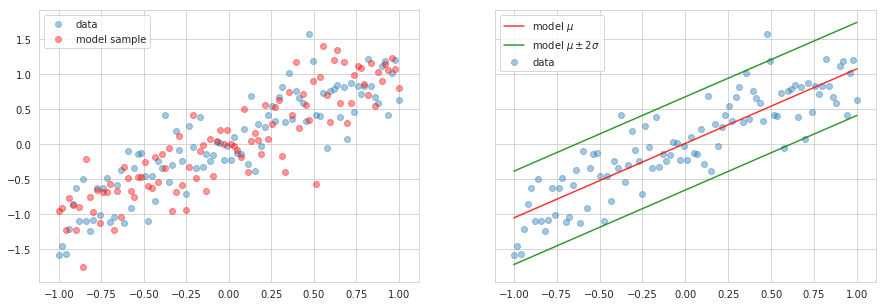

In [122]:
_plot(x_train=x_train, y_train=y_train, model=model)

The model now fits the data much better.

#### Tensorflow simplification

There is another way to instantiate the model above, making it simpler.

In [124]:
model = Sequential([
    Dense(units=2, input_shape=(1,)), # 1 loc + 1 scale
    tfpl.IndependentNormal(1) # '1' here refers to the event_shape
])
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 2)                 4         
_________________________________________________________________
independent_normal_15 (Indep ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


We could also replace the hardcoded `units=2` when instantiating the `Dense` layer by `Dense(units=tfpl.IndependentNormal.params_size(event_shape=1))` to automatically infer the number of parameters needed by the distribution.

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

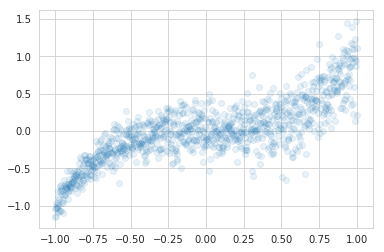

In [125]:
# Create and plot 10000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [127]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'), # the activation function makes it non-linear
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=lambda y_true, y_pred: -y_pred.log_prob(y_true), optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 18        
_________________________________________________________________
independent_normal_17 (Indep ((None, 1), (None, 1))    0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [128]:
# Train model

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

1000/1000 [==============================] - 0s 205us/sample - loss: -0.1849


-0.18489691185951232


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



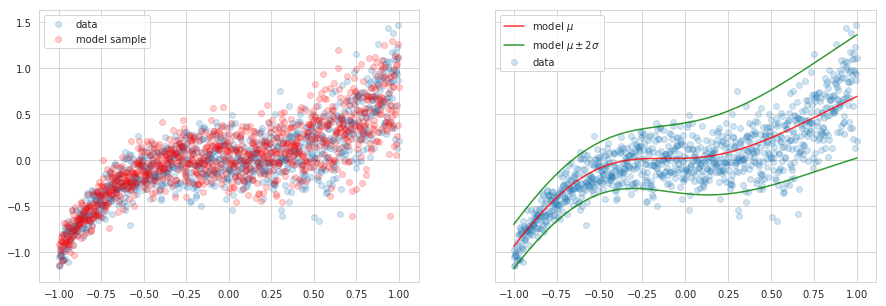

In [129]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
ax1.scatter(x_train, y_train, alpha=0.2, label='data')
ax1.scatter(x_train, y_sample, alpha=0.2, color='red', label='model sample')
ax1.legend()
ax2.scatter(x_train, y_train, alpha=0.2, label='data')
ax2.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax2.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax2.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax2.legend()
plt.show()